# Considerações:
- Exemplo de busca semântica em documentos jurídicos 
- [Pinecone](https://www.pinecone.io/) será utilizado para armazenamento de embeddings

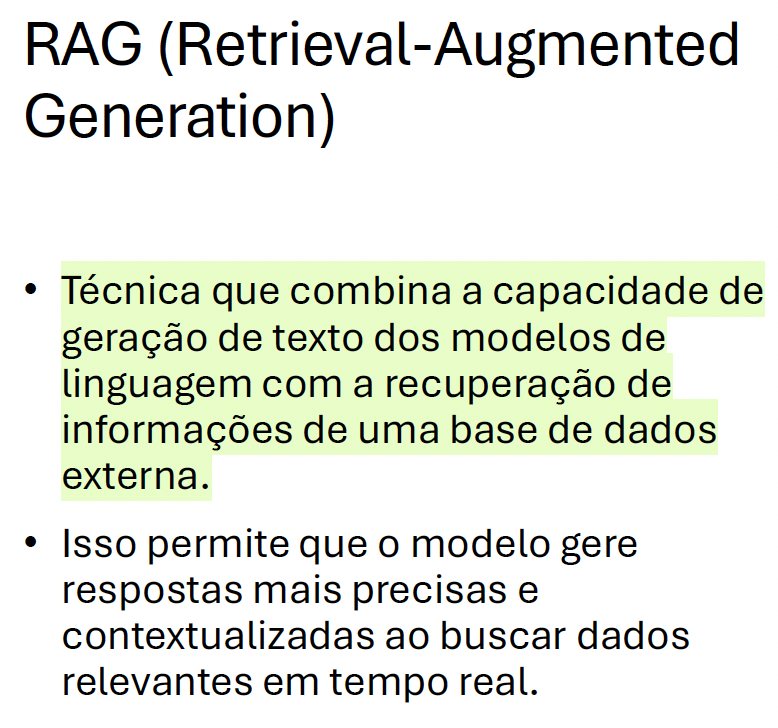

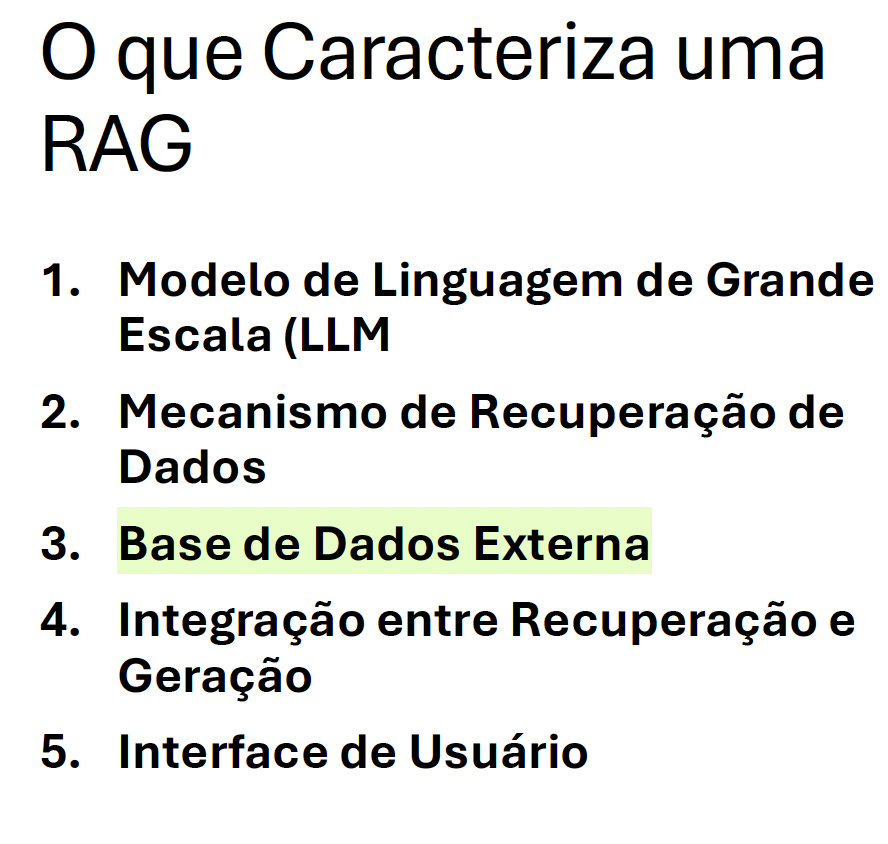

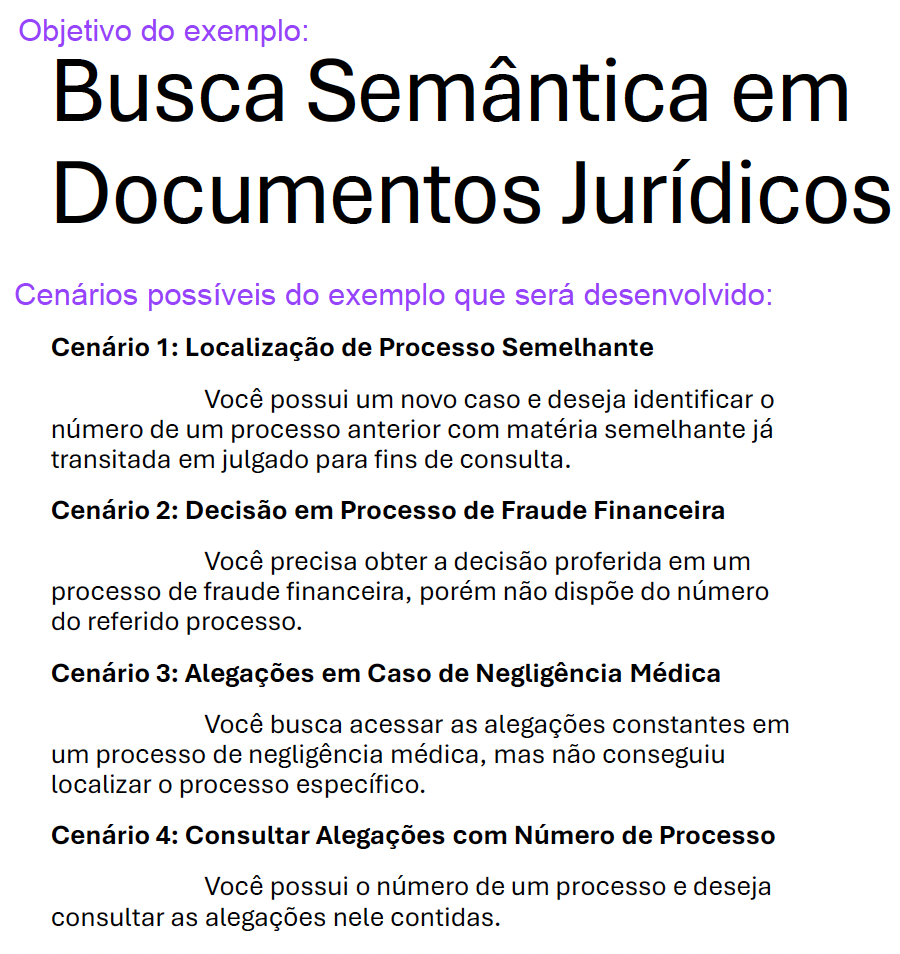

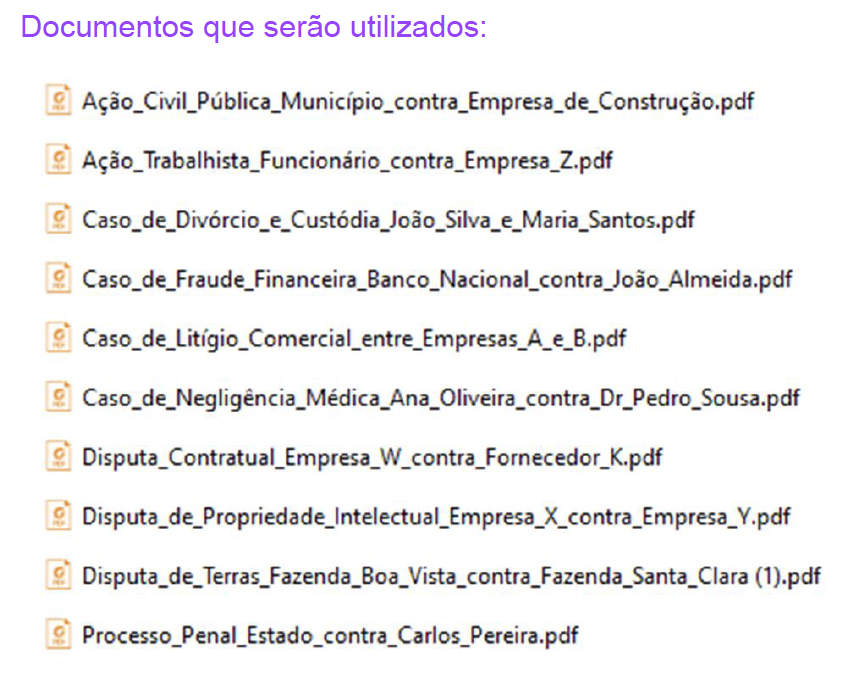

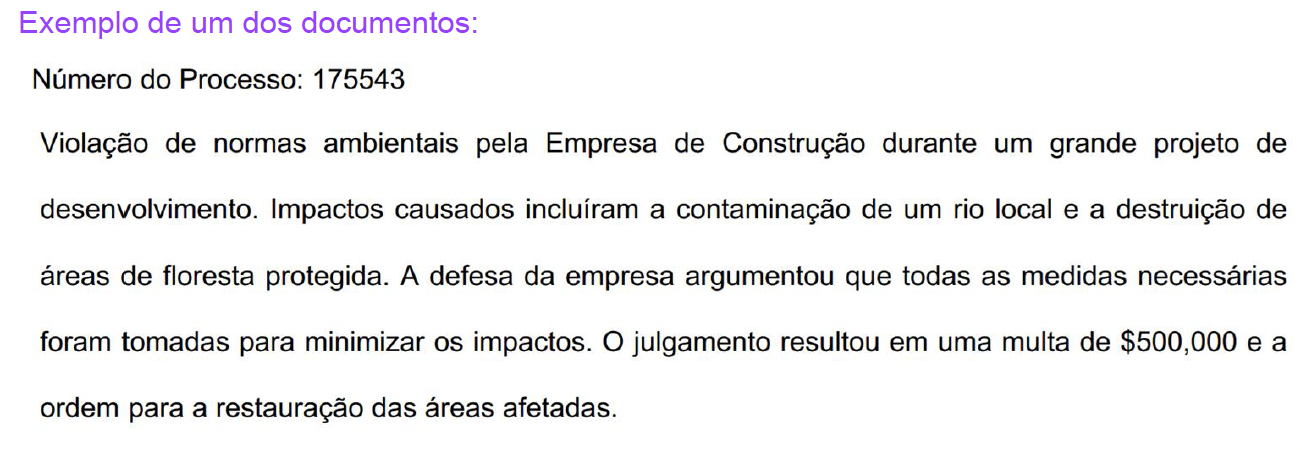

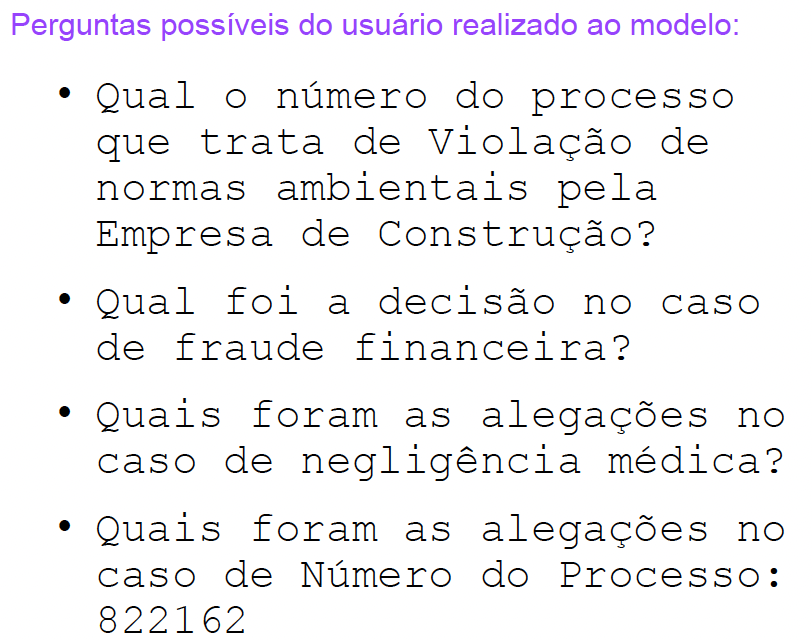

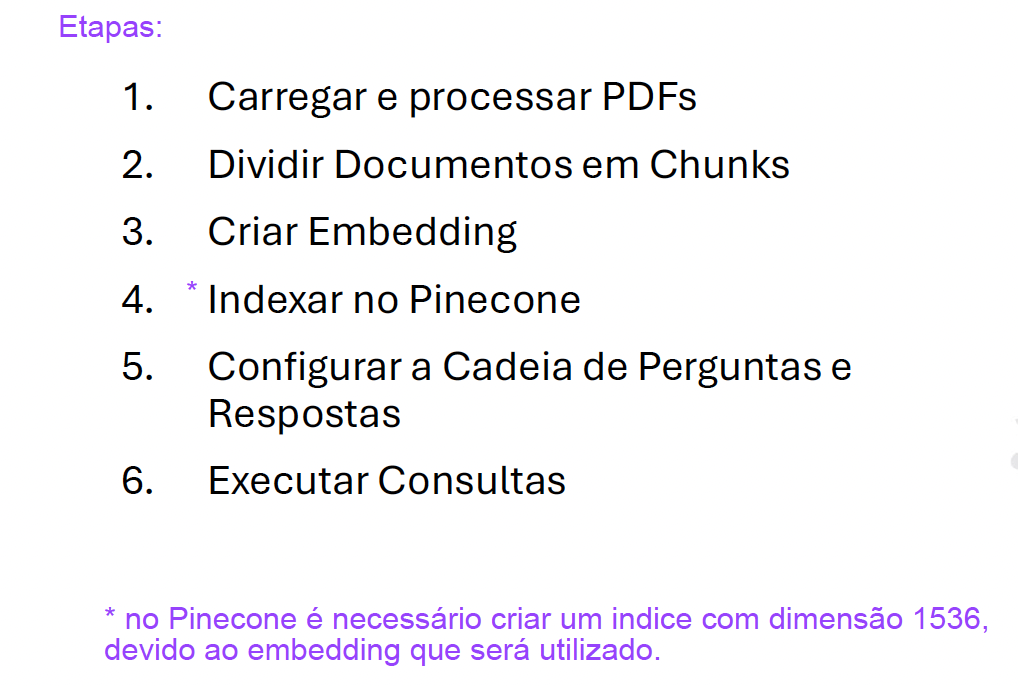

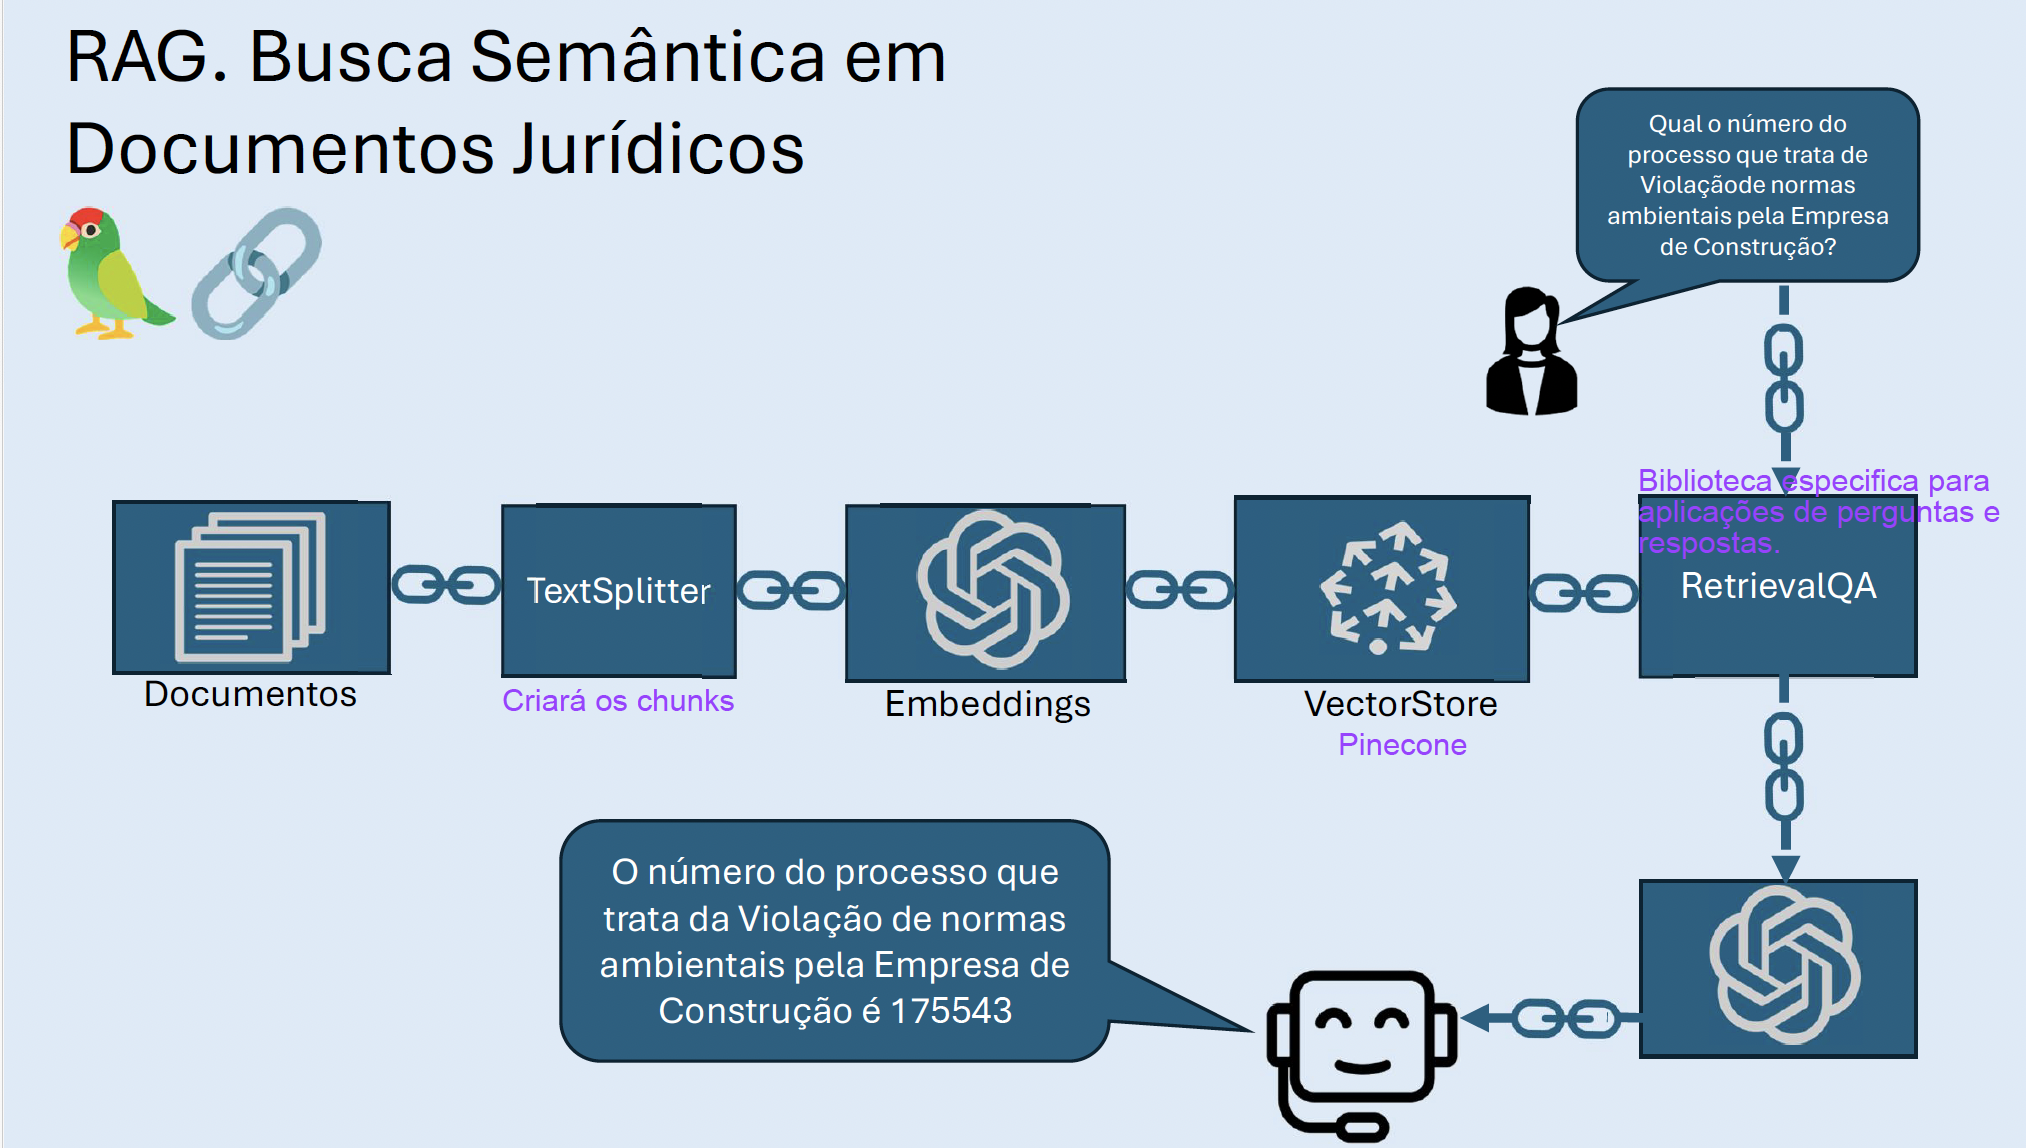

# Setup

In [1]:
# importando as bibliotecas

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import PyMuPDFLoader # carrega os pdfs
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Pinecone as PineconeVectorStore
from langchain.chains import RetrievalQA
from langchain_openai import ChatOpenAI
from pinecone import Pinecone
import yaml
import os
import zipfile

In [2]:
# lendo o arquivo config.yaml para ter acesso a chave de acesso do Pinecone e OpenAI

with open('config.yaml', 'r') as config_file:
    config = yaml.safe_load(config_file)
os.environ['PINECONE_API_KEY'] = config['PINECONE_API_KEY']
os.environ['OPENAI_API_KEY'] = config['OPENAI_API_KEY']

# Busca Semântica

In [3]:
# Os documentos estão em um arquivo zip, será extraido os arquivos zipados

zip_file_path = 'documentos.zip' # variável que guarda o nome do arquivo zip
extracted_folder_path = 'docs' # pasta que será armazenada os documentos deszipados

# descompactação dos arquivos dentro da pasta docs
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

documents = []
for filename in os.listdir(extracted_folder_path):
    if filename.endswith(".pdf"):
        file_path = os.path.join(extracted_folder_path, filename)
        loader = PyMuPDFLoader(file_path)
        documents.extend(loader.load())

# ao rodar a célula cria-se uma pasta chamada docs com os arquivo descompactados vindos do arquivo: documentos.zip

In [4]:
# Divisão dos documentos em chunks

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  
    chunk_overlap=100,
    length_function=len
)
chunks = text_splitter.create_documents([doc.page_content for doc in documents])

In [6]:
# visualizando os chunks

print("\nChunks gerados:")
for i, chunk in enumerate(chunks):
    print(f"Chunk {i+1}: {chunk.page_content}")


Chunks gerados:
Chunk 1: Número do Processo: 539252
Detalhes do contrato entre as empresas A e B. Motivos da disputa incluem alegações de quebra de
contrato, falta de pagamento e entrega de produtos defeituosos. A Empresa A alega que a
Empresa B não cumpriu os prazos acordados e forneceu produtos de qualidade inferior. A Empresa
B argumenta que a Empresa A não fez os pagamentos conforme o contrato. A decisão judicial
favoreceu a Empresa A, ordenando que a Empresa B pague uma indenização de $500,000.
Chunk 2: Número do Processo: 953588
Acusações criminais de fraude e evasão fiscal contra Carlos Pereira. As provas apresentadas
incluíram documentos financeiros, testemunhos de ex-associados e registros bancários. A defesa
argumentou que as transações foram legais e que as acusações eram baseadas em
mal-entendidos. O veredicto foi de culpado, com Carlos Pereira sentenciado a cinco anos de prisão
e uma multa de $200,000.
Chunk 3: Número do Processo: 405642
Alegações de violação de patentes 

In [8]:
# Criando o objeto OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model='text-embedding-ada-002') 

In [9]:
# Armazenando os embeddings no indice criado no Pinecone

index_name = 'rag' 
vector_store = PineconeVectorStore.from_documents(chunks, embeddings, index_name=index_name)

In [10]:
# Prompt com as perguntas que serão feitas ao modelo

query_1 = '''Responda apenas com base no input fornecido. Qual o número do processo que trata de Violação
de normas ambientais pela Empresa de Construção?'''
query_2 = 'Responda apenas com base no input fornecido. Qual foi a decisão no caso de fraude financeira?'
query_3 = 'Responda apenas com base no input fornecido. Quais foram as alegações no caso de negligência médica?'
query_4 = 'Responda apenas com base no input fornecido. Quais foram as alegações no caso de Número do Processo: 822162' #disputa contratual

In [11]:
# Instanciando o objeto ChatOpenAI

llm = ChatOpenAI(model='gpt-3.5-turbo', temperature=0.2)

In [12]:
# Criação do objeto retriever
# vector_store é uma instância do PineconeVectorStore
# as_retriever: transforma o vector_store em um objeto retriever. De forma que ele possa ser usado para buscar itens baseados em consutlas
# search_kwargs={'k': 3}: indica que os 3 documentos mais parecidos serão retornados

retriever = vector_store.as_retriever(search_type='similarity', search_kwargs={'k': 3})

In [13]:
# Criação do objeto chain da classe RetrievalQA
# RetrievalQA: classe que representa processo de perguntas e resposta
# from_chain_type: cria uma instância do RetrievalQA a partir de uma cadeia/chain, no caso, usando o chain_type='stuff'

chain = RetrievalQA.from_chain_type(llm=llm, chain_type='stuff', retriever=retriever)

In [15]:
print(retriever) # imprimindo o objeto retriever

tags=['Pinecone', 'OpenAIEmbeddings'] vectorstore=<langchain_community.vectorstores.pinecone.Pinecone object at 0x116641400> search_kwargs={'k': 3}


In [14]:
print(chain)  # imprimindo o objeto chain. Mais completo

combine_documents_chain=StuffDocumentsChain(llm_chain=LLMChain(prompt=ChatPromptTemplate(input_variables=['context', 'question'], messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context'], template="Use the following pieces of context to answer the user's question. \nIf you don't know the answer, just say that you don't know, don't try to make up an answer.\n----------------\n{context}")), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['question'], template='{question}'))]), llm=ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x12d5f72f0>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x12d5f7ce0>, temperature=0.2, openai_api_key=SecretStr('**********'), openai_proxy='')), document_variable_name='context') retriever=VectorStoreRetriever(tags=['Pinecone', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.pinecone.Pinecone object at 0x116641400>, search_kwargs={'k': 3

In [16]:
# Chamando o modelo através do objeto chain e passando as perguntas

answer_1 = chain.invoke(query_1)
answer_2 = chain.invoke(query_2)
answer_3 = chain.invoke(query_3)
answer_4 = chain.invoke(query_4)

In [17]:
# Imprimindo os resultados do modelo 

print('Pergunta: ',answer_1['query'])
print('Resultado: ',answer_1['result'],'\n')
#---
print('Pergunta: ',answer_2['query'])
print('Resultado: ',answer_2['result'],'\n')
#---
print('Pergunta: ',answer_3['query'])
print('Resultado: ',answer_3['result'],'\n')
#---
print('Pergunta: ',answer_4['query'])
print('Resultado: ',answer_4['result'])

Pergunta:  Responda apenas com base no input fornecido. Qual o número do processo que trata de Violação
de normas ambientais pela Empresa de Construção?
Resultado:  O número do processo que trata da Violação de normas ambientais pela Empresa de Construção é 175543. 

Pergunta:  Responda apenas com base no input fornecido. Qual foi a decisão no caso de fraude financeira?
Resultado:  A decisão no caso de fraude financeira envolvendo João Almeida foi uma sentença de dez anos de prisão e a restituição de $1,000,000 ao Banco Nacional. 

Pergunta:  Responda apenas com base no input fornecido. Quais foram as alegações no caso de negligência médica?
Resultado:  As alegações no caso de negligência médica foram de que o Dr. Pedro Sousa não realizou os procedimentos médicos com o cuidado necessário, resultando em complicações graves, incluindo uma cirurgia mal-sucedida que levou a infecções adicionais. 

Pergunta:  Responda apenas com base no input fornecido. Quais foram as alegações no caso de N